# Main
Deep coins embedding and search similar

In [1]:
import tensorflow as tf
import numpy as np
from scipy import spatial

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_dc_grt = global_run_tests
global_run_tests = False

%run embedding_model.ipynb
%run similarity_model.ipynb


global_run_tests = _dc_grt

In [13]:
dataset_path = "/netforge/datasets/private/roman/coins/images"
image_shape  = [128, 128, 1]
data_size    = 300

## Load data

In [14]:
def load_data(path, image_shape, data_size):
    data = Dataset(image_shape)
    data.load(path, data_size)
    return data

data = load_data(dataset_path, image_shape, data_size)

## Compute TSN similarity

compute_joint_probabilities
  batch 0 ... 
joint_probs: [1, 300, 300]
sum 1.0


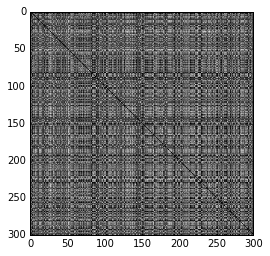

In [13]:
def compute_tsne_joint_probs(samples, batch_size):
    joint_probs = compute_joint_probabilities(
        samples    = np.reshape(samples, [len(samples), -1]),
        batch_size = batch_size)
    print("joint_probs:", list(joint_probs.shape))
    print("sum", joint_probs.sum())
    for p in joint_probs:
        plt.imshow(p**.1, cmap='gray')
        plt.show()
    return joint_probs

similarity = compute_tsne_joint_probs(
    samples    = data.train_images, 
    batch_size = data.data_size)

## Train  similarity model

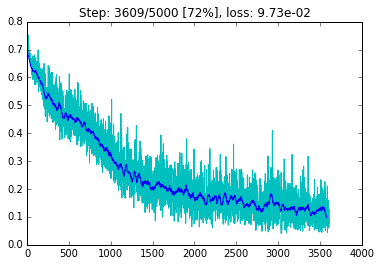

path         : /netforge/datasets/private/roman/coins/images
data_size    : 300
aug_num      : 42
batch_size   : 100
learning_rate: 1e-04
0.99 0.85 0.95 0.75 0.96 0.93 0.94 0.98 0.97 0.99 0.95 0.99 0.99 0.91 0.72 0.99 0.98 0.97 0.98 0.96
==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ====


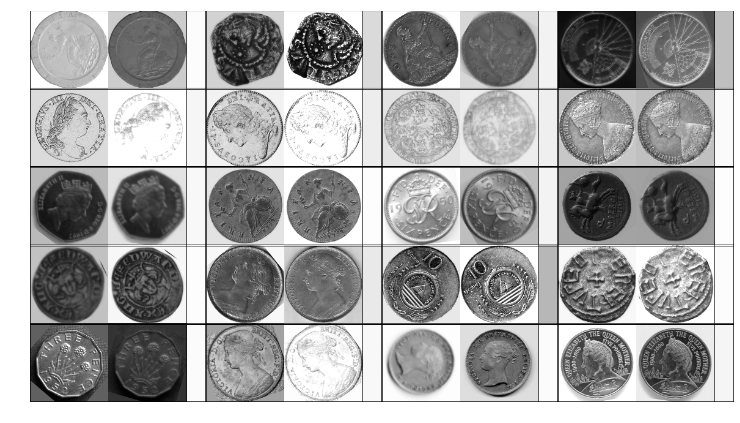

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.03 0.01 0.13 0.00 0.77 0.00 0.00
                                                                                     ====          


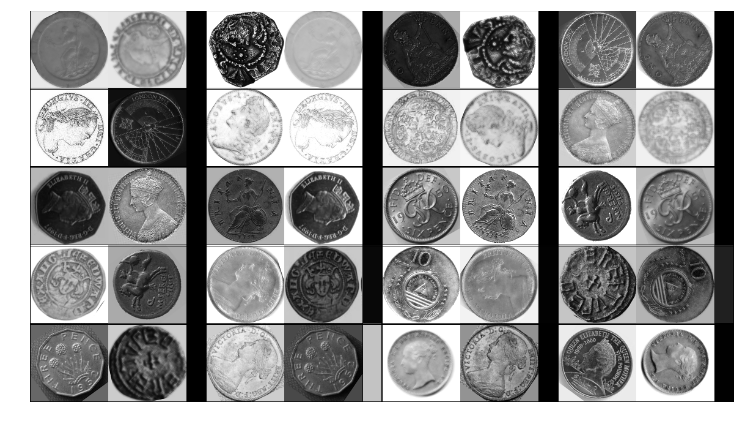

CPU times: user 16min 48s, sys: 5min 54s, total: 22min 42s
Wall time: 17min 25s


In [4]:
%%time
def train_sim_model(data, aug_num, step_num, batch_size, learning_rate, stop_loss):
    aug   = Augmentator(cache_size = aug_num)
    model = SimiratityModel(data, aug)
    model.build()
    model.train(
        step_num      = step_num, 
        batch_size    = batch_size, 
        learning_rate = learning_rate, 
        stop_loss     = stop_loss)
    print("path         :", model.data.path)
    print("data_size    :", model.data.data_size)
    print("aug_num      :", aug_num)
    print("batch_size   :", batch_size)
    print("learning_rate: %.0e" % learning_rate)
    return model

sim_model = train_sim_model(
    data          = data, 
    aug_num       = 42,
    step_num      = 5000, 
    batch_size    = 100, 
    learning_rate = 1e-4, 
    stop_loss     = .1)

test_similarity(sim_model, 20)

### Compute and save joint probs

In [5]:
import itertools

num   = data_size
pairs = np.asarray(list(itertools.product(range(num), range(num))))

def make_batches(arr, bs):
    batches = []
    for i in range(0, len(arr), bs):
        batches.append(arr[i:i+bs])
    return batches


def get_fake_similarity(model, idx1, idx2):
    return np.asarray(idx1 == idx2).astype(np.float)

def get_similarity(model, idx1, idx2):
    img1 = model.data.train_images[idx1]
    img2 = model.data.train_images[idx2]
    sim  = model.get_similarity(img1, img2)
    return sim

bs = 100
batches = make_batches(pairs, bs)

joint_probs = np.zeros([1, num,num])
p = joint_probs
eps       = 10e-15
for i in range(len(p)):
    for j in range(len(p[i])):
        p[i,j,j] = 0
    p[i] = p[i] / (p[i].sum()+eps)

for i in range(len(joint_probs)):
    p[i] = p[i] / (p[i].sum()+eps)
    p[i] = np.maximum(p[i], np.finfo(p[i].dtype).eps)

for i,b in enumerate(batches):
    clear_output(True)
    print(i, "/", len(batches))
    idx1  = b[:,0]
    idx2  = b[:,1]
    sim = get_similarity(sim_model, idx1, idx2)
    for s in range(len(sim)):
        joint_probs[0, idx1[s], idx2[s]] = sim[s]

# make diag probs = 0
# todo -- normilize probs
np.save("joint_probs.npy", joint_probs)

899 / 900


## Restore saved similarity

joint_probs: [1, 300, 300]
sum 1.00000000001


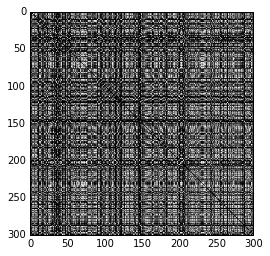

In [11]:
joint_probs = np.load("joint_probs.npy")
print("joint_probs:", list(joint_probs.shape))
print("sum", joint_probs.sum())
similarity = joint_probs

for p in joint_probs:
    plt.imshow(p**.06, cmap='gray')
    plt.show()

## Learn embedding

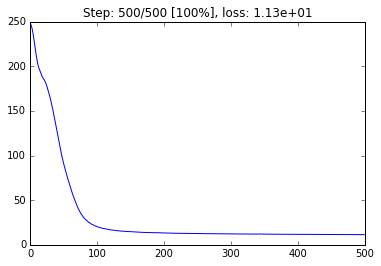

In [15]:
def train_embedding_model(data, step_num, batch_size, learning_rate, embed_dims):
    model = EmbeddingModel(data, embed_dims, batch_size)
    model = EmbeddingModel(data, embed_dims, batch_size)
    model.build(similarity)
    model.train(step_num)
    return model

embed_model = train_embedding_model(
    data          = data, 
    step_num      = 500, 
    batch_size    = data.data_size, 
    learning_rate = 1e-4, 
    embed_dims    = 30)

database: [300, 30]
targets : [32, 30]


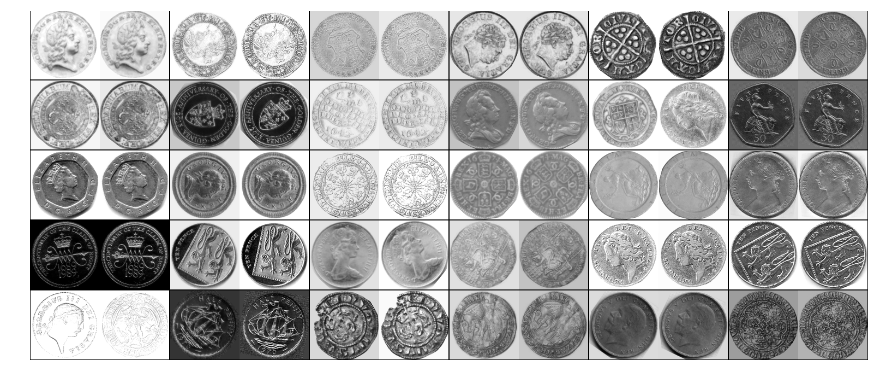

In [26]:
def test_embedding(model, num):
    assert model, "Model is not defined"
    aug  = Augmentator(cache_size = 42)
    rate = .5

    database_images = model.data.test_images
    for i in range(len(database_images)):
        database_images[i] = aug.augment(database_images[i], rate=0)
    
    database = model.embed_images(database_images)
    
    idx = np.arange(model.data.data_size)
    np.random.shuffle(idx)
    target_images = model.data.test_images[idx][:num]
    for i in range(len(target_images)):
        target_images[i] = aug.augment(target_images[i], rate=rate)
    targets = model.embed_images(target_images)
    
    nearests, distances = find_nearest(database, targets)
    nearest_images = database_images[nearests]
    
    print("database:", list(database.shape))
    print("targets :", list(targets.shape))
    show_nearest(target_images, nearest_images, num)
    
test_embedding(embed_model, 32)